# Part 2
# Author: Georgios Pligoropoulos < george@pligor.com >

In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from os import path, remove
import numpy as np
import pandas as pd
from csv import QUOTE_ALL
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
import shutil
from sklearn.metrics import r2_score
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import operator
from os.path import isfile, isdir, join
from os import getcwd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE, \
    MatrixFactorization, BiScaler
from math import floor

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
n_jobs = 1
%matplotlib inline

In [4]:
from advanced_one_hot_encoder import AdvancedOneHotEncoder

**Short sale** explained: http://www.investopedia.com/terms/r/real-estate-short-sale.asp

## Load Data

In [5]:
twin_cities_path = join(getcwd(), 'twin_cities.csv')
df = pd.read_csv(twin_cities_path, delimiter = ',', encoding='utf-8', quoting=QUOTE_ALL, index_col=0)
df.shape

(1111, 20)

In [6]:
df[:5]

,ADDRESS,CITY,STATE,ZIP,ListPrice,BEDS,BATHS,LOCATION,SQFT,LotSize,YearBuilt,ParkingSpots,HasGarage,DOM,LastSaleDate,SoldPrev,Realty,LATITUDE,LONGITUDE,ShortSale
ID,,,,,,,,,,,,,,,,,,,,
4416206,1000 Larpenteur Ave W,St. Paul,MN,55113,214000,3,2,Como,1954,6969.0,1918,2,Garage,117,6/10/2008,Y,"Edina Realty, Inc.","44,991634","-93,142616",N
4423768,1004 Charles Ave,St. Paul,MN,55104,134900,3,1,Thomas-Dale (Frogtown),1028,4356.0,1911,1,Garage,93,8/11/2010,Y,Fish MLS Realty,"44,957291","-93,142624",N
4427963,1004 Euclid St,St. Paul,MN,55106,129722,4,1,Dayton's Bluff,1420,5227.0,1900,0,No Garage,77,NaN,N,Coldwell Banker Burnet,"44,954708","-93,057976",N
4432178,1005 Saint Anthony Ave,St. Paul,MN,55104,134900,2,"1,75",Summit-University,904,8712.0,1928,3,Garage,57,NaN,N,"Real Estate Masters, Ltd.","44,952404","-93,142693",N
4440070,100X Chatsworth Pl,Shoreview,MN,55126,444900,4,"2,5",Shoreview,2014,12632.0,2014,3,Garage,8,NaN,N,Coldwell Banker Burnet,"44,944391","-93,141348",N


## Drop redundant columns
State column does not hold any information since it is the same for all instances
Also we are dropping last sale date as we are advised to not use it but also because it contains lots of nulls

In [7]:
if 'STATE' in df.columns:
    df = df.drop(labels=['STATE'], axis=1)
if 'LastSaleDate' in df.columns:
    df = df.drop(labels=['LastSaleDate'], axis=1)
df.shape

(1111, 18)

### Keep columns for Price Regression

In [8]:
#Regression Columns
#CITY, ZIP, BEDS, BATHS, SQFT, LotSize, YearBuilt, ParkingSpots, HasGarage, LATITUDE, LONGITUDE, ShortSale
XX = df[
    ['CITY', 'ZIP', 'BEDS', 'BATHS', 'SQFT', 'LotSize', 'YearBuilt', 'ParkingSpots', 'HasGarage', 'LATITUDE',
     'LONGITUDE', 'ShortSale']
]
XX.shape

(1111, 12)

In [9]:
#target: ListPrice
yy = df['ListPrice']
yy.shape

(1111,)

### Numerify data
, already numerical

In [10]:
XX['BEDS'].dtype

dtype('int64')

In [11]:
XX['SQFT'].dtype

dtype('int64')

In [12]:
XX['LotSize'].dtype

dtype('float64')

In [13]:
XX['ParkingSpots'].dtype

dtype('int64')

In [14]:
if XX['BATHS'].dtype == 'object':
    XX['BATHS'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['BATHS']]
XX['BATHS'].dtype

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


dtype('float64')

#### CITY

In [15]:
print len(XX['CITY'].unique())
XX['CITY'].unique()

6


array([u'St. Paul', u'Shoreview', u'Minneapolis', u'Woodbury',
       u'West St. Paul', u'Maplewood'], dtype=object)

In [16]:
if 'CITY' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='CITY')
XX.shape

(1111, 16)

#### ZIP

In [17]:
#comparing locations and zips lengths
print len(df['LOCATION'].unique())
print len(df['ZIP'].unique())

86
33


In [18]:
if 'ZIP' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='ZIP')
XX.shape

(1111, 47)

#### Year Built to Age

In [19]:
if 'YearBuilt' in XX.columns:
    XX['age'] = 2014 - XX['YearBuilt']
    XX.drop(labels='YearBuilt', axis=1, inplace=True)
assert 'age' in XX.columns
XX.shape

(1111, 47)

#### Has Garage to binary

In [20]:
XX['HasGarage'].unique()

array([u'Garage', u'No Garage'], dtype=object)

In [21]:
if 'Garage' in XX['HasGarage'].unique():
    XX['HasGarage'] = XX['HasGarage'] == 'Garage'
XX['HasGarage'].unique()

array([True, False], dtype=object)

#### Short Sale to binary

In [22]:
XX['ShortSale'].unique()

array([u'N', u'Y'], dtype=object)

In [23]:
if 'Y' in XX['ShortSale'].unique():
    XX['ShortSale'] = XX['ShortSale'] == 'Y'
XX['ShortSale'].unique()

array([False, True], dtype=object)

#### Latitude

In [24]:
if XX['LATITUDE'].dtype == 'object':
    XX['LATITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LATITUDE']]
XX['LATITUDE'].dtype

dtype('float64')

#### Longitude

In [25]:
if XX['LONGITUDE'].dtype == 'object':
    XX['LONGITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LONGITUDE']]
XX['LONGITUDE'].dtype

dtype('float64')

### Fill the Gaps
Rule of thumb of KNN to pick a neighborhood of 1%

In [26]:
XX.isnull().sum()

BEDS             0
BATHS            1
SQFT             0
LotSize         64
ParkingSpots     0
HasGarage        0
LATITUDE         6
LONGITUDE        6
ShortSale        0
CITY_0           0
CITY_1           0
CITY_2           0
CITY_3           0
CITY_4           0
ZIP_0            0
ZIP_1            0
ZIP_2            0
ZIP_3            0
ZIP_4            0
ZIP_5            0
ZIP_6            0
ZIP_7            0
ZIP_8            0
ZIP_9            0
ZIP_10           0
ZIP_11           0
ZIP_12           0
ZIP_13           0
ZIP_14           0
ZIP_15           0
ZIP_16           0
ZIP_17           0
ZIP_18           0
ZIP_19           0
ZIP_20           0
ZIP_21           0
ZIP_22           0
ZIP_23           0
ZIP_24           0
ZIP_25           0
ZIP_26           0
ZIP_27           0
ZIP_28           0
ZIP_29           0
ZIP_30           0
ZIP_31           0
age              0
dtype: int64

In [27]:
#before
null_sum = sum(XX.isnull().sum())
null_sum

77

In [28]:
k_factor = int(floor(len(XX) * 0.01))
k_factor

11

In [29]:
if null_sum > 0:
    XX[XX.columns] = KNN(k=k_factor).complete(XX.values)

Imputing row 1/1111 with 0 missing, elapsed time: 0.445
Imputing row 101/1111 with 1 missing, elapsed time: 0.447
Imputing row 201/1111 with 1 missing, elapsed time: 0.447
Imputing row 301/1111 with 0 missing, elapsed time: 0.448
Imputing row 401/1111 with 0 missing, elapsed time: 0.449
Imputing row 501/1111 with 0 missing, elapsed time: 0.449
Imputing row 601/1111 with 0 missing, elapsed time: 0.450
Imputing row 701/1111 with 0 missing, elapsed time: 0.450
Imputing row 801/1111 with 0 missing, elapsed time: 0.451
Imputing row 901/1111 with 0 missing, elapsed time: 0.451
Imputing row 1001/1111 with 0 missing, elapsed time: 0.452
Imputing row 1101/1111 with 0 missing, elapsed time: 0.453


In [30]:
XX.sample(random_state=random_state)

,BEDS,BATHS,SQFT,LotSize,ParkingSpots,HasGarage,LATITUDE,LONGITUDE,ShortSale,CITY_0,...,ZIP_23,ZIP_24,ZIP_25,ZIP_26,ZIP_27,ZIP_28,ZIP_29,ZIP_30,ZIP_31,age
ID,,,,,,,,,,,,,,,,,,,,,
4433532,4.0,1.5,1685.0,6534.0,2.0,1.0,45.045876,-93.289268,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,64.0


In [31]:
sum(XX.isnull().sum())

0

# Question 2
All things being equal what would you predict as the listing price for a 2111 square foot
house if that was the only information you had on a house in this area? How did you
arrive at that estimate? Please explain.

In [32]:
target_sqft = 2111.

Features independent of area:  
Beds, Baths, Sqft, LotSize, ParkingSpots, HasGarage, ShortSale, age

For the area we specify City, Zip code and we take the average of latitude and longitude of that area.  
We also take the average of the rest of the features for that area since we only have available the LotSize.

In [33]:
best_alpha = 0.0057223676593502202

In [34]:
XX.columns

Index([        u'BEDS',        u'BATHS',         u'SQFT',      u'LotSize',
       u'ParkingSpots',    u'HasGarage',     u'LATITUDE',    u'LONGITUDE',
          u'ShortSale',       u'CITY_0',       u'CITY_1',       u'CITY_2',
             u'CITY_3',       u'CITY_4',        u'ZIP_0',        u'ZIP_1',
              u'ZIP_2',        u'ZIP_3',        u'ZIP_4',        u'ZIP_5',
              u'ZIP_6',        u'ZIP_7',        u'ZIP_8',        u'ZIP_9',
             u'ZIP_10',       u'ZIP_11',       u'ZIP_12',       u'ZIP_13',
             u'ZIP_14',       u'ZIP_15',       u'ZIP_16',       u'ZIP_17',
             u'ZIP_18',       u'ZIP_19',       u'ZIP_20',       u'ZIP_21',
             u'ZIP_22',       u'ZIP_23',       u'ZIP_24',       u'ZIP_25',
             u'ZIP_26',       u'ZIP_27',       u'ZIP_28',       u'ZIP_29',
             u'ZIP_30',       u'ZIP_31',          u'age'],
      dtype='object')

In [35]:
model = Ridge(alpha=best_alpha, normalize=True).fit(XX, yy)
model

Ridge(alpha=0.00572236765935, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [36]:
model.score(XX, yy)

0.7808430886161426

In [37]:
zip_counts = df.groupby(['ZIP'])['ZIP'].count()
zip_counts

ZIP
55101      2
55102     25
55103     14
55104     79
55105     53
55106    133
55107     31
55108     15
55113      1
55114      1
55116     44
55117     55
55118      3
55119     42
55126      2
55129      1
55130     19
55404      3
55405      8
55406     72
55407     57
55408     18
55409     16
55410     56
55411     45
55412    107
55413      9
55416      8
55417     59
55418     47
55419     59
55421      2
55430     25
Name: ZIP, dtype: int64

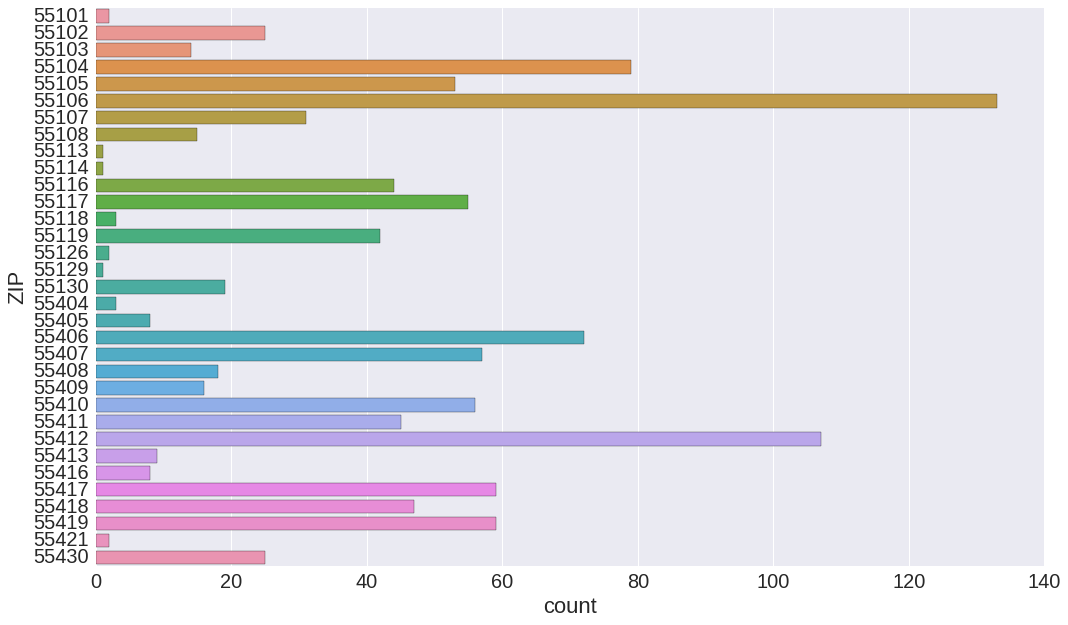

In [38]:
sns.set(font_scale=2)
plt.figure(figsize=(17,10))
sns.countplot(data=df, y='ZIP')
plt.show()

In [39]:
print "which zip code is closer to the average"
target_zip = np.argmin( (zip_counts - np.mean(zip_counts))**2 )
target_zip

which zip code is closer to the average


55107

In [40]:
print "this is how many homes we have in this zip code:"
zip_counts[target_zip]

this is how many homes we have in this zip code:


31

In [41]:
target_inds = df[df['ZIP'] == target_zip].index
target_inds

Index([u'4399602', u'4410942', u'4416440', u'4414396', u'4430034', u'4441237',
       u'4437833', u'4440968', u'4428985', u'4399584', u'4423945', u'4401782',
       u'4436783', u'4414297', u'4401035', u'4440692', u'4403464', u'4420124',
       u'4405470', u'4429734', u'4427420', u'4435274', u'4429588', u'4408106',
       u'4405033', u'4434599', u'4431325', u'4441404', u'4415200', u'4437698',
       u'4397927'],
      dtype='object', name=u'ID')

In [42]:
df[df['ZIP'] == target_zip].sample(random_state=random_state)

,ADDRESS,CITY,ZIP,ListPrice,BEDS,BATHS,LOCATION,SQFT,LotSize,YearBuilt,ParkingSpots,HasGarage,DOM,SoldPrev,Realty,LATITUDE,LONGITUDE,ShortSale
ID,,,,,,,,,,,,,,,,,,
4405033,629 Hall Ave,St. Paul,55107,169900,4,"1,5",West Side,1544,7405.0,1900,3,Garage,137,N,"Edina Realty, Inc.","44,926994","-93,087036",N


In [43]:
sample_home = str(4405033)

So let's consider for the sake of example that we are searching in St. Paul with zip code 55107

In [44]:
test_inst = XX.loc[sample_home]
test_inst

BEDS               4.000000
BATHS              1.500000
SQFT            1544.000000
LotSize         7405.000000
ParkingSpots       3.000000
HasGarage          1.000000
LATITUDE          44.926994
LONGITUDE        -93.087036
ShortSale          0.000000
CITY_0             0.000000
CITY_1             0.000000
CITY_2             1.000000
CITY_3             0.000000
CITY_4             0.000000
ZIP_0              0.000000
ZIP_1              0.000000
ZIP_2              0.000000
ZIP_3              0.000000
ZIP_4              0.000000
ZIP_5              1.000000
ZIP_6              0.000000
ZIP_7              0.000000
ZIP_8              0.000000
ZIP_9              0.000000
ZIP_10             0.000000
ZIP_11             0.000000
ZIP_12             0.000000
ZIP_13             0.000000
ZIP_14             0.000000
ZIP_15             0.000000
ZIP_16             0.000000
ZIP_17             0.000000
ZIP_18             0.000000
ZIP_19             0.000000
ZIP_20             0.000000
ZIP_21             0

In [45]:
zip_inds = [ind for ind in test_inst.index if 'ZIP' in ind]
np.array(zip_inds)

array(['ZIP_0', 'ZIP_1', 'ZIP_2', 'ZIP_3', 'ZIP_4', 'ZIP_5', 'ZIP_6',
       'ZIP_7', 'ZIP_8', 'ZIP_9', 'ZIP_10', 'ZIP_11', 'ZIP_12', 'ZIP_13',
       'ZIP_14', 'ZIP_15', 'ZIP_16', 'ZIP_17', 'ZIP_18', 'ZIP_19',
       'ZIP_20', 'ZIP_21', 'ZIP_22', 'ZIP_23', 'ZIP_24', 'ZIP_25',
       'ZIP_26', 'ZIP_27', 'ZIP_28', 'ZIP_29', 'ZIP_30', 'ZIP_31'], 
      dtype='|S6')

In [46]:
test_inst[zip_inds]

ZIP_0     0.0
ZIP_1     0.0
ZIP_2     0.0
ZIP_3     0.0
ZIP_4     0.0
ZIP_5     1.0
ZIP_6     0.0
ZIP_7     0.0
ZIP_8     0.0
ZIP_9     0.0
ZIP_10    0.0
ZIP_11    0.0
ZIP_12    0.0
ZIP_13    0.0
ZIP_14    0.0
ZIP_15    0.0
ZIP_16    0.0
ZIP_17    0.0
ZIP_18    0.0
ZIP_19    0.0
ZIP_20    0.0
ZIP_21    0.0
ZIP_22    0.0
ZIP_23    0.0
ZIP_24    0.0
ZIP_25    0.0
ZIP_26    0.0
ZIP_27    0.0
ZIP_28    0.0
ZIP_29    0.0
ZIP_30    0.0
ZIP_31    0.0
Name: 4405033, dtype: float64

In [47]:
XX_area = XX[XX['ZIP_5']==1]
XX_area.shape

(31, 47)

In [48]:
average_age = np.round(np.mean(XX_area['age']))
test_inst['age'] = average_age
average_age

90.0

In [49]:
average_latitude = np.mean(XX_area['LATITUDE'])
test_inst['LATITUDE'] = average_latitude
average_latitude

44.92574629032257

In [50]:
average_LONGITUDE = np.mean(XX_area['LONGITUDE'])
test_inst['LONGITUDE'] = average_LONGITUDE
average_LONGITUDE

-93.08591264516132

In [51]:
average_BEDS = np.round(np.mean(XX_area['BEDS']))
test_inst['BEDS'] = average_BEDS
average_BEDS

3.0

In [52]:
average_BATHS = np.round( np.mean(XX_area['BATHS']) * 2 ) / 2.
test_inst['BATHS'] = average_BATHS
average_BATHS

1.5

In [53]:
print "compare the average sqft of the area with the target sqft"
print target_sqft
np.mean(XX_area['SQFT'])

compare the average sqft of the area with the target sqft
2111.0


1460.1612903225807

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
  if __name__ == '__main__':


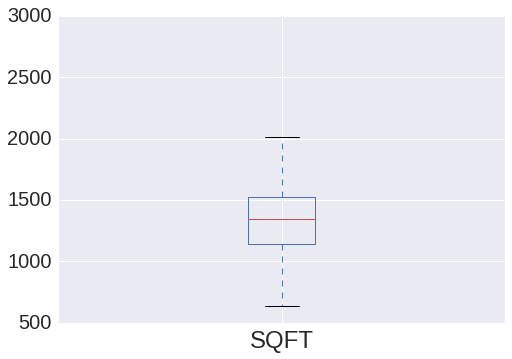

In [54]:
XX_area['SQFT'].to_frame().boxplot()
plt.show()

So according to the boxplot above it is obvious that a house with 2111 sqft would be considered an outlier

But recall that we have chosen a random area, so perhaps in a real situation we would not fall into this case where a very large house would appear in an area that perhaps does not have room of such large houses

In [55]:
test_inst['SQFT'] = target_sqft
test_inst['SQFT']

2111.0

In [56]:
average_LotSize = np.round( np.mean(XX_area['LotSize']) )
test_inst['LotSize'] = average_LotSize
average_LotSize

5681.0

In [57]:
average_ParkingSpots = np.round( np.mean(XX_area['ParkingSpots']) )
test_inst['ParkingSpots'] = average_ParkingSpots
average_ParkingSpots

2.0

In [58]:
most_freq_HasGarage = int(np.sum(XX_area['HasGarage']) / len(XX_area) >= 0.5)
test_inst['HasGarage'] = most_freq_HasGarage
most_freq_HasGarage

1

In [59]:
most_freq_ShortSale = int(np.sum(XX_area['ShortSale']) / len(XX_area) >= 0.5)
test_inst['ShortSale'] = most_freq_ShortSale
most_freq_ShortSale

0

In [60]:
print "this is the price that we are predicting for the a house of certain zip code and city and of 2111 sqft"
model.predict(test_inst.values.reshape(1,-1))

this is the price that we are predicting for the a house of certain zip code and city and of 2111 sqft


array([ 319198.37645277])

In [67]:
def originalModel_getPrice(target_zip, target_sqft):
    target_inds = df[df['ZIP'] == target_zip].index
    XX_area = XX.loc[target_inds]
    assert len(XX_area) > 0, "target zip {} has no instances??".format(target_zip)
    test_inst = XX_area.iloc[0]
    test_inst['age'] = np.round(np.mean(XX_area['age']))
    test_inst['LATITUDE'] = np.mean(XX_area['LATITUDE'])
    test_inst['LONGITUDE'] = np.mean(XX_area['LONGITUDE'])
    test_inst['BEDS'] = np.round(np.mean(XX_area['BEDS']))
    test_inst['BATHS'] = np.round( np.mean(XX_area['BATHS']) * 2 ) / 2.
    test_inst['SQFT'] = target_sqft
    test_inst['LotSize'] = np.round( np.mean(XX_area['LotSize']) )
    test_inst['ParkingSpots'] = np.round( np.mean(XX_area['ParkingSpots']) )
    test_inst['HasGarage'] = int(np.sum(XX_area['HasGarage']) / len(XX_area) >= 0.5)
    test_inst['ShortSale'] = int(np.sum(XX_area['ShortSale']) / len(XX_area) >= 0.5)
    #print test_inst.shape
    return model.predict(test_inst.values.reshape(1,-1))[0]

In [68]:
zips = [55105, 55116, 55408, 55409, 55410, 55419, 55102]

In [69]:
orig_model_res = {}
for zip_code in zips:
    orig_model_res[zip_code] = originalModel_getPrice(target_zip=zip_code, target_sqft=target_sqft)

orig_model_res

{55102: 375390.50264020264,
 55105: 379688.47903862596,
 55116: 391439.97434100509,
 55408: 530891.45318065584,
 55409: 453609.28939040005,
 55410: 565426.21209213138,
 55419: 361722.30597694218}

# Alternatives

In [70]:
from sklearn.preprocessing import LabelEncoder

In [71]:
le = LabelEncoder()

In [72]:
le.fit(df['ZIP'])

LabelEncoder()

In [73]:
XX.shape

(1111, 47)

In [74]:
df.shape

(1111, 18)

In [75]:
XX['ZIP'] = df['ZIP'] #just append this our table

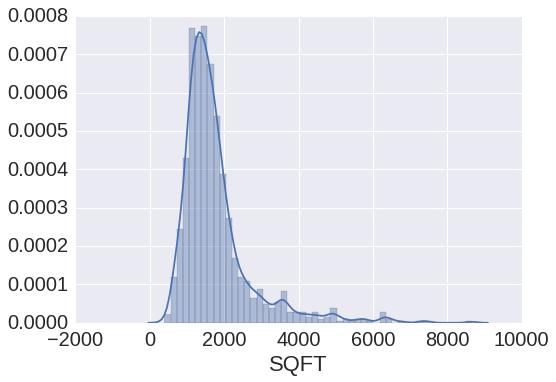

In [76]:
sns.distplot(XX['SQFT'])
plt.show()

In [77]:
#choose an area
cur_ins = XX[XX['ZIP'] == 55410]
cur_tars = yy[XX['ZIP'] == 55410]
cur_tars.shape

(56,)

In [78]:
#for all listings in an area find the sqft one std from mean but the distribution is not that gaussian
#so you could take the Q1 and Q3 quartiles and see if it is within that range

In [79]:
thresholds = np.percentile(cur_ins['SQFT'], [25, 75])
thresholds

array([ 1711.75,  3631.25])

In [80]:
#check if target threshold is within this range, if not do NOT proceed with this area as we cannot be certain
is_within_range = thresholds[0] <= target_sqft <= thresholds[1]
is_within_range

True

In [81]:
k=3

In [82]:
sq_dists = (cur_ins['SQFT'] - target_sqft)**2
sq_dists[:5]

ID
4415763     269361.0
4440599     491401.0
4436308     960400.0
4434982    2111209.0
4440352     567009.0
Name: SQFT, dtype: float64

In [83]:
closests = sq_dists.sort_values(ascending=True)[:k]
closests

ID
4431409      169.0
4433198    53824.0
4369066    66564.0
Name: SQFT, dtype: float64

In [84]:
close_prices = cur_tars.loc[closests.index]
close_prices

ID
4431409    334900
4433198    249900
4369066    259900
Name: ListPrice, dtype: int64

In [85]:
np.mean(close_prices)

281566.6666666667

In [86]:
def getExpectedPrice(dataframe, zip_code, target_sqft, kk=3):
    filtering = dataframe['ZIP'] == zip_code
    cur_sqfts = dataframe[filtering]['SQFT']
    cur_tars = dataframe[filtering]['ListPrice']
    thresholds = np.percentile(cur_sqfts, [25, 75])
    is_within_range = thresholds[0] <= target_sqft <= thresholds[1]
    if is_within_range:
        sq_dists = (cur_sqfts - target_sqft)**2
        closests = sq_dists.sort_values(ascending=True)[:kk]
        close_prices = cur_tars.loc[closests.index]
        return np.mean(close_prices)
    else:
        return None

In [87]:
zip_codes = df['ZIP'].unique()
zip_codes

array([55113, 55104, 55106, 55126, 55418, 55116, 55103, 55117, 55105,
       55419, 55129, 55417, 55411, 55130, 55108, 55102, 55119, 55413,
       55107, 55408, 55407, 55412, 55118, 55409, 55405, 55406, 55114,
       55404, 55410, 55416, 55101, 55430, 55421])

In [88]:
expected_per_zip_code = dict([(zip_code, price) for (zip_code, price) in [(zip_code, getExpectedPrice(
                dataframe=df,
                target_sqft=2111.,
                zip_code=zip_code)) for zip_code in zip_codes]
 if price is not None])

len(expected_per_zip_code)

7

In [89]:
len(zip_codes)

33

In [90]:
expected_per_zip_code.keys()

[55105, 55116, 55408, 55409, 55410, 55419, 55102]

In [91]:
zips_to_play = df[np.in1d(df['ZIP'], expected_per_zip_code.keys())].groupby('ZIP').count()['ADDRESS']
zips_to_play

ZIP
55102    25
55105    53
55116    44
55408    18
55409    16
55410    56
55419    59
Name: ADDRESS, dtype: int64

In [94]:
knn_df = pd.DataFrame({
        'knn': expected_per_zip_code.values(),
    }, index = expected_per_zip_code.keys())
knn_df

,knn
55105,398233.333333
55116,446600.000000
55408,279933.333333
55409,363233.333333
55410,281566.666667
55419,498266.666667
55102,358300.000000


In [96]:
multi_df = pd.DataFrame({
        'multi': orig_model_res.values(),
    }, index = orig_model_res.keys())
multi_df.shape

(7, 1)

In [97]:
pd.concat((knn_df, multi_df), axis=1)

,knn,multi
55105,398233.333333,379688.479039
55116,446600.000000,391439.974341
55408,279933.333333,530891.453181
55409,363233.333333,453609.289390
55410,281566.666667,565426.212092
55419,498266.666667,361722.305977
55102,358300.000000,375390.502640


# Alternative 2

In [98]:
from ecdf import ecdf
from bootstrap_pairs_linear_regression import draw_bs_pairs_linreg

In [99]:
target_zip = 55419
target_sqft = 2111.

In [100]:
cur_ins = XX[df['ZIP']== target_zip]
cur_ins.shape

(59, 48)

In [101]:
cur_tars = yy[df['ZIP'] == target_zip]
cur_tars.shape

(59,)

In [102]:
cur_sqft = cur_ins['SQFT']
cur_sqft.shape

(59,)

In [103]:
from bootstrap_replicates import draw_bootstrap_replicates

In [104]:
cdfs = draw_bootstrap_replicates(ecdf, 50, random_state, cur_sqft)
len(cdfs)

50

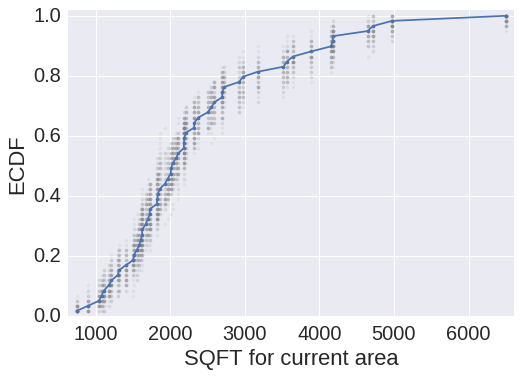

In [105]:
for ii in range(len(cdfs)):
    cur_cdf = cdfs[ii]
    plt.plot(cur_cdf[0], cur_cdf[1], marker='.', linestyle='none',
                 color='gray',
             alpha=0.1)

#Compute and plot ECDF from original data
x, y = ecdf(cur_sqft)
_ = plt.plot(x, y, marker='.')

# Make margins and label axes
plt.margins(0.02)
_ = plt.xlabel('SQFT for current area')
_ = plt.ylabel('ECDF')

# Show the plot
plt.show()

In [106]:
from ecdf import plot_ecdf_bootstrap_replicates

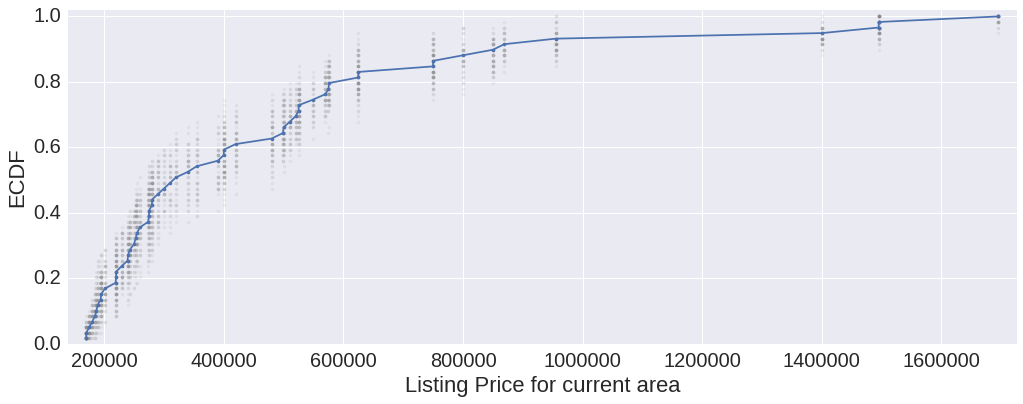

In [107]:
plt.figure(figsize=(17,6))
plot_ecdf_bootstrap_replicates(50, random_state, cur_tars, xlabel='Listing Price for current area')
plt.show()

In [108]:
sqft_means = draw_bootstrap_replicates(np.mean, 10000, random_state, cur_sqft)
len(sqft_means)

10000

In [109]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 7)
#mpl.rcParams['lines.color'] = 'r'

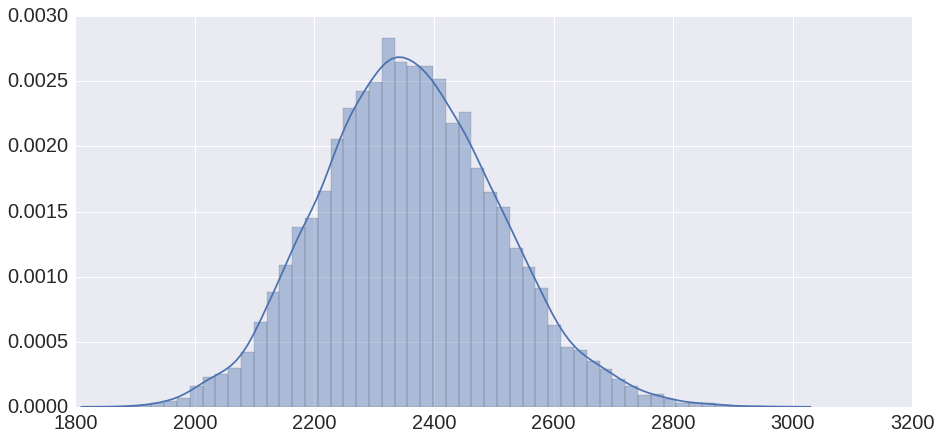

In [110]:
#plt.figure(figsize=(15,7))
sns.distplot(sqft_means)
plt.show()

In [111]:
np.percentile(sqft_means, [2.5, 97.5]) #95% confidence interval

array([ 2081.22033898,  2668.77372881])

In [112]:
np.percentile(sqft_means, [5, 95]) #90% confidence interval

array([ 2124.57118644,  2610.50169492])

In [113]:
assert len(cur_tars) == len(cur_sqft)

In [114]:
price_means = draw_bootstrap_replicates(np.mean, 10000, random_state, cur_tars)
len(price_means)

10000

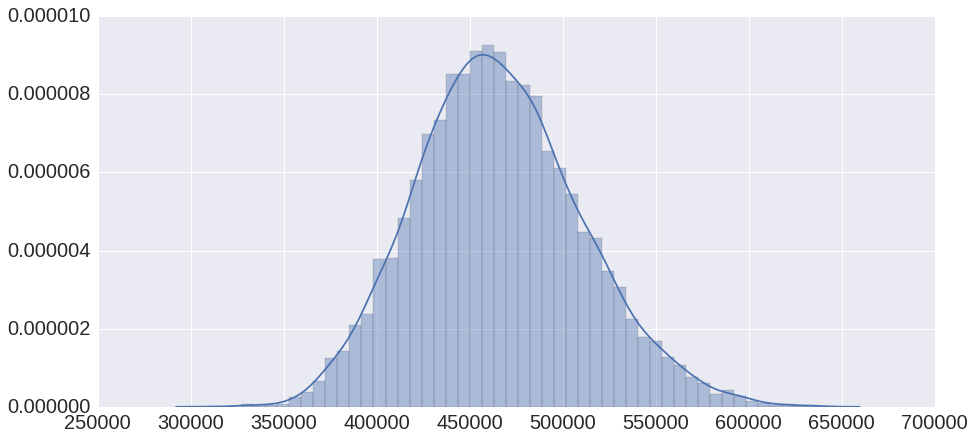

In [115]:
sns.distplot(price_means)
plt.show()

In [116]:
np.percentile(price_means, [5, 95]) #90%

array([ 395580.20762712,  543489.11694915])

In [117]:
slope_replicates, intercept_replicates = draw_bs_pairs_linreg(
    cur_sqft, cur_tars, size=1000, random_state=random_state)
len(slope_replicates), len(intercept_replicates)

(1000, 1000)

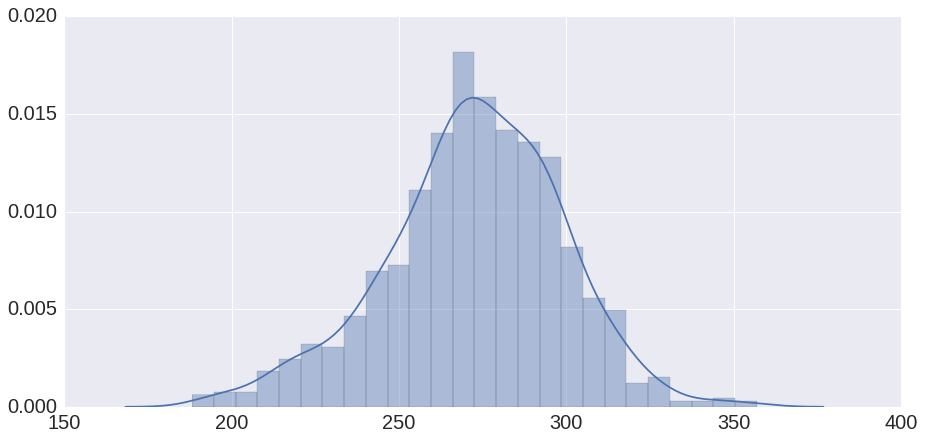

In [118]:
sns.distplot(slope_replicates)
plt.show()

In [119]:
from bootstrap_pairs_linear_regression import plot_bs_pairs_linreg

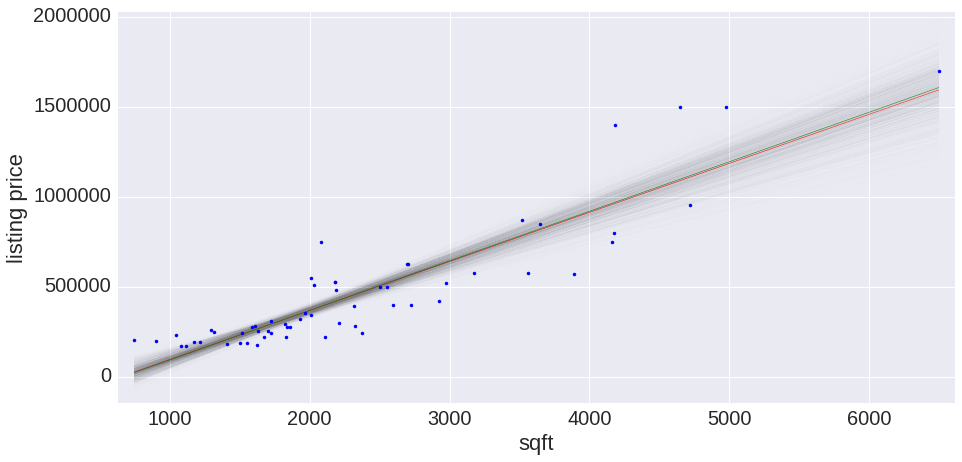

In [120]:
plot_bs_pairs_linreg(x_data=cur_sqft, y_data=cur_tars, slopes = slope_replicates, intercepts=intercept_replicates,
                     xlabel = 'sqft', ylabel='listing price')
plt.show()

In [121]:
zips

[55105, 55116, 55408, 55409, 55410, 55419, 55102]

In [123]:
def simple_linreg(target_zip, target_sqft):
    ins = XX[df['ZIP']== target_zip]['SQFT']
    tars = yy[df['ZIP'] == target_zip]
    slope, intercept = np.polyfit(ins,tars,deg=1)
    return slope*target_sqft + intercept

In [124]:
target_sqft

2111.0

In [126]:
simple_res = {}
for zipcode in zips:
    simple_res[zipcode] = simple_linreg(target_zip = zipcode, target_sqft=target_sqft)
    
simple_res

{55102: 337967.83486642188,
 55105: 411834.25393735548,
 55116: 379246.49717784207,
 55408: 522604.30523372203,
 55409: 456406.97049109405,
 55410: 417230.16452804499,
 55419: 397987.36864462413}

In [127]:
simple_df = pd.DataFrame({
        'simple': simple_res.values(),
    }, index = simple_res.keys())
simple_df

,simple
55105,411834.253937
55116,379246.497178
55408,522604.305234
55409,456406.970491
55410,417230.164528
55419,397987.368645
55102,337967.834866


# Comparison

In [128]:
pd.concat((knn_df, multi_df, simple_df), axis=1)

,knn,multi,simple
55105,398233.333333,379688.479039,411834.253937
55116,446600.000000,391439.974341,379246.497178
55408,279933.333333,530891.453181,522604.305234
55409,363233.333333,453609.289390,456406.970491
55410,281566.666667,565426.212092,417230.164528
55419,498266.666667,361722.305977,397987.368645
55102,358300.000000,375390.502640,337967.834866


In [134]:
knn_flat = knn_df.rename(columns={'knn': 'price'}).reset_index()
knn_flat['type'] = 'knn'

multi_flat = multi_df.rename(columns={'multi': 'price'}).reset_index()
multi_flat['type'] = 'multi'

simple_flat = simple_df.rename(columns={'simple': 'price'}).reset_index()
simple_flat['type'] = 'simple'

In [135]:
merged_df = pd.concat((knn_flat,
           multi_flat,
           simple_flat), axis=0)

merged_df

,index,price,type
0,55105,398233.333333,knn
1,55116,446600.000000,knn
2,55408,279933.333333,knn
3,55409,363233.333333,knn
4,55410,281566.666667,knn
5,55419,498266.666667,knn
6,55102,358300.000000,knn
0,55105,379688.479039,multi
1,55116,391439.974341,multi
2,55408,530891.453181,multi


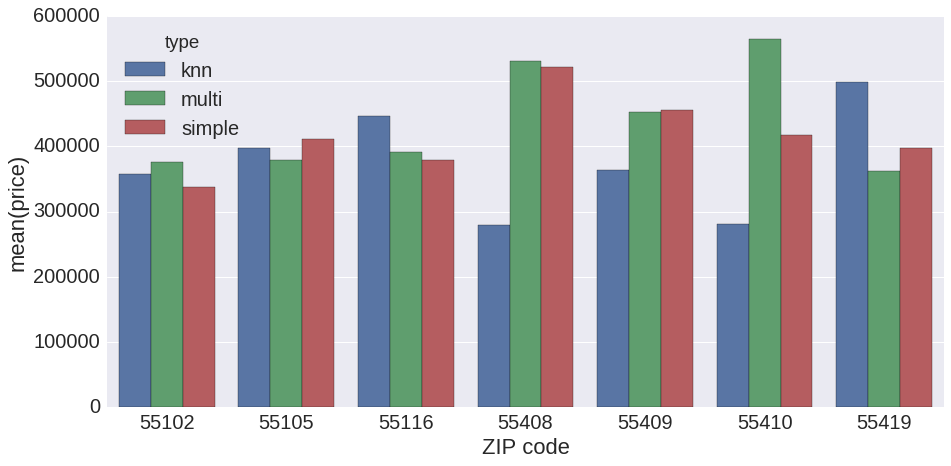

In [139]:
sns.barplot(data=merged_df, y='price', x='index', hue='type')
plt.xlabel('ZIP code')
plt.show()